IMPORT AND DISPLAY DEMO DATASET

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))


# Define the path to your dataset
anime_face_path = '/kaggle/input/animefacedataset'

# Load the dataset
batch_size = 32  # You can adjust the batch size if needed
train_images = tf.keras.utils.image_dataset_from_directory(
    anime_face_path,
    label_mode=None,
    image_size=(64, 64),
    batch_size=batch_size,
    shuffle=True
)

# Function to display images
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n+1)
        plt.imshow(image_batch[n].numpy().astype("uint8"))
   


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DEVICES AVAILABLE: 2
Found 63565 files belonging to 1 classes.


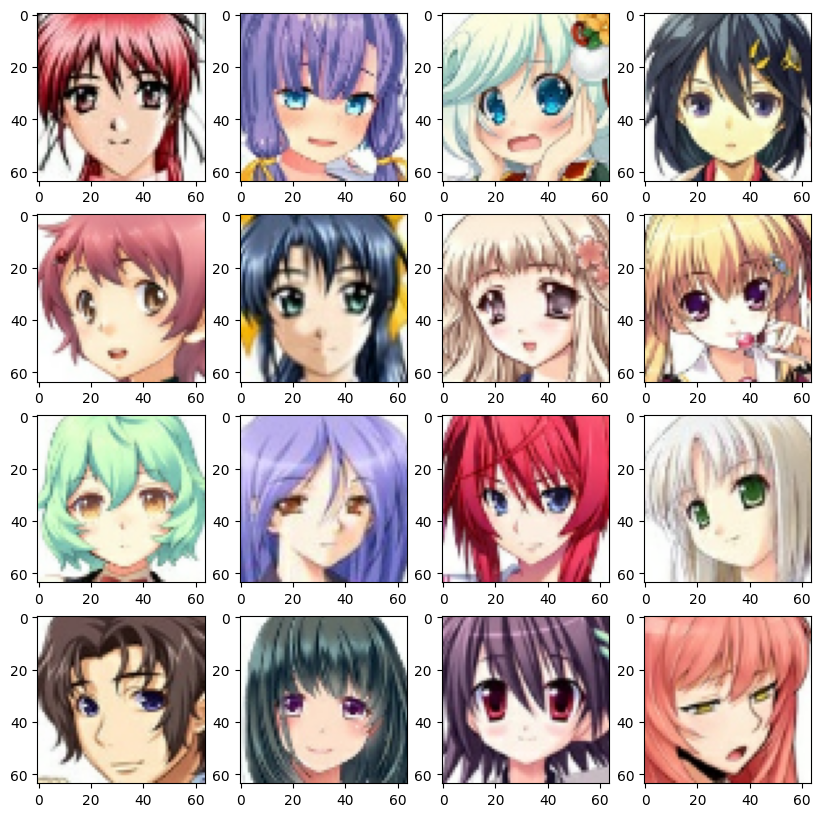

In [2]:
# Display a batch of images
for image_batch in train_images.take(1):
    show_batch(image_batch)

DISPLAY GENERATED IMAGES USING DISTIRBUTED TRAINING

Number of devices: 2
Found 63565 files belonging to 1 classes.
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


994/994 [==============================] - 63s 48ms/step - d_loss: 31.8539 - g_loss: 172.2221
Epoch 2/100
994/994 [==============================] - 31s 31ms/step - d_loss: 41.0498 - g_loss: 129.9175
Epoch 3/100
994/994 [==============================] - 32s 32ms/step - d_loss: 52.5034 - g_loss: 124.1823
Epoch 4/100
994/994 [==============================] - 31s 31ms/step - d_loss: 53.9953 - g_loss: 109.4277
Epoch 5/100
994/994 [==============================] - 31s 31ms/step - d_loss: 63.1086 - g_loss: 95.6547
Epoch 6/100
994/994 [==============================] - 32s 32ms/step - d_loss: 64.9993 - g_loss: 94.4895
Epoch 7/100
994/994 [==============================] - 31s 31ms/step - d_loss: 65.8176 - g_loss: 91.2917
Epoch 8/100
994/994 [==============================] - 31s 31ms/step - d_loss: 63.5318 - g_loss: 93.1897
Epoch 9/100
994/994 [==============================] - 31s 31ms/step - d_loss: 60.3631 - g_loss: 98.6327
Epoch 10/100
994/994 [==============================] - 32s 32m

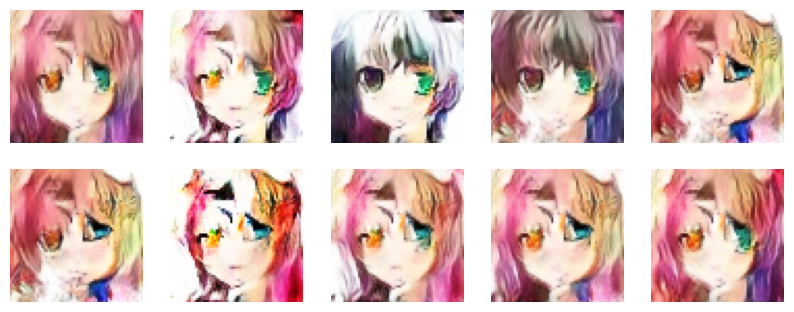

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Initialize MirroredStrategy for distributed training on multiple GPUs
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Adjust batch size according to the number of GPUs
batch_size = 32 * strategy.num_replicas_in_sync

# Discriminator Model
def Discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Generator Model
def Generator():
    model = Sequential()
    model.add(Dense(256 * 8 * 8, input_dim=100))
    model.add(Reshape((8, 8, 256)))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

# Loading Anime Face Dataset
anime_face_path = '/kaggle/input/animefacedataset'
train_images = tf.keras.utils.image_dataset_from_directory(
    anime_face_path,
    label_mode=None,
    image_size=(64, 64),
    batch_size=batch_size,
    shuffle=True
).map(lambda x: (x - 127.5) / 127.5)  # Normalize the images to [-1, 1]

# Define the GAN class
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 100))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, 100))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

# Build and compile the models within the strategy scope
with strategy.scope():
    discriminator = Discriminator()
    generator = Generator()

    gan = GAN(discriminator=discriminator, generator=generator)
    gan.compile(
        d_optimizer=Adam(1e-4),
        g_optimizer=Adam(1e-4),
        loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    )

# Train the model
epochs = 100
gan.fit(train_images, epochs=epochs)

# Generate some images after training
def display_generated_images(model, num_images=10):
    random_latent_vectors = tf.random.normal(shape=(num_images, 100))
    generated_images = model(random_latent_vectors)
    generated_images = (generated_images * 127.5 + 127.5).numpy().astype('int32')

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

display_generated_images(generator)


OPTIONAL- TO SAVE IMAGES GENERATED

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import os

# Initialize MirroredStrategy for distributed training on multiple GPUs
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Adjust batch size according to the number of GPUs
batch_size = 32 * strategy.num_replicas_in_sync

# Discriminator Model
def Discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Generator Model
def Generator():
    model = Sequential()
    model.add(Dense(256 * 8 * 8, input_dim=100))
    model.add(Reshape((8, 8, 256)))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

# Loading Anime Face Dataset
anime_face_path = '/kaggle/input/animefacedataset'
train_images = tf.keras.utils.image_dataset_from_directory(
    anime_face_path,
    label_mode=None,
    image_size=(64, 64),
    batch_size=batch_size,
    shuffle=True
).map(lambda x: (x - 127.5) / 127.5)  # Normalize the images to [-1, 1]

# Define the GAN class
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 100))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, 100))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        print("am I here- 1")
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        print("am I here- 2")
        return {"d_loss": d_loss, "g_loss": g_loss}

# Build and compile the models within the strategy scope
with strategy.scope():
    discriminator = Discriminator()
    generator = Generator()

    gan = GAN(discriminator=discriminator, generator=generator)
    gan.compile(
        d_optimizer=Adam(1e-4),
        g_optimizer=Adam(1e-4),
        loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    )

# Train the model
epochs = 50
gan.fit(train_images, epochs=epochs)

# Generate some images after training
def display_generated_images(model, num_images=10):
    random_latent_vectors = tf.random.normal(shape=(num_images, 100))
    generated_images = model(random_latent_vectors)
    generated_images = (generated_images * 127.5 + 127.5).numpy().astype('int32')

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

def save_generated_images(model, directory='generated_images', num_images=10):
    os.makedirs(directory, exist_ok=True)
    random_latent_vectors = tf.random.normal(shape=(num_images, 100))
    generated_images = model(random_latent_vectors)
    generated_images = (generated_images * 127.5 + 127.5).numpy().astype('uint8')

    for i in range(num_images):
        img = Image.fromarray(generated_images[i])
        img.save(os.path.join(directory, f'generated_image_{i+1}.png'))

# Displaying generated images
save_generated_images(generator)


Number of devices: 2
Found 63565 files belonging to 1 classes.
Epoch 1/50
am I here- 1
am I here- 1
am I here- 2
am I here- 2
am I here- 1
am I here- 1
am I here- 2
am I here- 2
994/994 [==============================] - 37s 32ms/step - d_loss: 35.2867 - g_loss: 143.9592
Epoch 2/50
994/994 [==============================] - 32s 32ms/step - d_loss: 43.0724 - g_loss: 135.8253
Epoch 3/50
994/994 [==============================] - 32s 32ms/step - d_loss: 51.0553 - g_loss: 110.9757
Epoch 4/50
994/994 [==============================] - 32s 32ms/step - d_loss: 52.3055 - g_loss: 117.8006
Epoch 5/50
994/994 [==============================] - 32s 32ms/step - d_loss: 60.4518 - g_loss: 108.6087
Epoch 6/50
994/994 [==============================] - 32s 32ms/step - d_loss: 65.5448 - g_loss: 91.0164
Epoch 7/50
994/994 [==============================] - 32s 32ms/step - d_loss: 68.3446 - g_loss: 83.4021
Epoch 8/50
994/994 [==============================] - 32s 32ms/step - d_loss: 74.3192 - g_loss: 80.9

SPARK HISTORY ALTERNATIVE FOR TENSFORFLOW AND IMAGE PROCESSING

In [5]:
%reload_ext tensorboard
%tensorboard --logdir logs

### 